# Developing functions to make better size and frame plots

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_size_and_frame_df(sam_file_path, gene_len_filepath):
    """Takes a sam file of mapped footprint counts and uses
    a corresponding gene length file (including 5' UTR, CDS, 
    and 3' UTR lengths) to create a footprint size x frame
    dataframe that can be used to determine A-site rules. 

    Args:
        sam_file_path (str): Path to sam file
        gene_len_filepath (str): Path to gene lengths file

    Returns:
        size_and_frame: Size by frame dataframe
    """    
    gene_len_df = pd.read_csv(
        gene_len_filepath,
        sep="\t", header=None, index_col=0)
    # Get 5' UTR length if all the values are the same
    global_utr5_len = None
    utr5_lens = gene_len_df.iloc[:, 0].unique()
    if len(utr5_lens) == 1:
        global_utr5_len = utr5_lens.item()
    # Read the sam file and count size and frame for each unique read
    size_and_frame_dict = {}
    utr5_len_dict = gene_len_df.iloc[:, 0].to_dict()
    gene_len_dict = gene_len_df.iloc[:, 1].to_dict()
    reads = set() # Store reads

    with open(sam_file_path, "r") as samfile:
        for line in samfile:
            if line[0] == "@":
                continue
            line = line.strip().split()
            read_id = line[0]
            # Don't count read if you've seen it before
            if read_id in reads:
                continue
            reads.add(read_id)
            gene = line[2]
            cds_len = gene_len_dict[gene]
            # If the 5' UTR is trimmed to a certain length for all transcripts, 
            # you don't have to look it up each iteration
            if global_utr5_len is not None:
                utr5_len = global_utr5_len
            else:
                utr5_len = utr5_len_dict[gene]
            # Get frame
            map_pos = int(line[3]) - 1 - utr5_len
            if map_pos < -15 or map_pos > cds_len - 9:
                continue
            frame = map_pos % 3
            # Get size 
            seq = line[9]
            size = len(seq)
            # Update dictionary
            if size not in size_and_frame_dict.keys():
                size_and_frame_dict[size] = {i : 0 for i in range(3)}
            size_and_frame_dict[size][frame] += 1
    size_and_frame = (
        pd.DataFrame(size_and_frame_dict)
        .T
        .sort_index()
        )
    return size_and_frame

def size_and_frame_counts_barplot(size_and_frame_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.barplot(size_and_frame_df.sum(axis=1), ax=ax)
    return ax

# def size_and_frame_counts_heatmap(size_and_frame_df, min_size:int = None, max_size:int = None):
#     """Creates a heatmap of size x frame dataframe between

#     Args:
#         size_and_frame_df (_type_): _description_
#         min_size (_type_): _description_
#         max_size (_type_): _description_
#     """    
#     size_and_frame_df = size_and_frame_df.loc[range(min_size, max_size + 1)]
#     sns.heatmap(size_and_frame_df, annot=True, cmap="viridis")

In [2]:
sam_file_path_full = "processed-data/thp1_v2/process/ansari.transcript.mapped.wts.sam"
sam_file_path_singlerun = "processed-data/thp1/process/ansari.transcript.mapped.wts.sam"
gene_len_filepath = "iXnos/genome_data/gencode.v22.transcript.13cds10.lengths.txt"

In [3]:
size_and_frame_singlerun = get_size_and_frame_df(sam_file_path_singlerun, gene_len_filepath)

In [4]:
size_and_frame_full = get_size_and_frame_df(sam_file_path_full, gene_len_filepath)

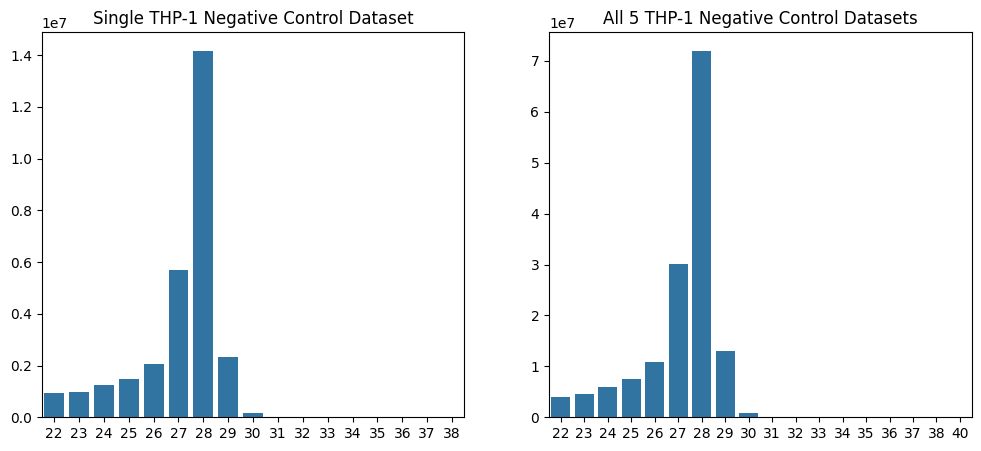

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
size_and_frame_counts_barplot(size_and_frame_singlerun, ax=axs[0])
axs[0].set_title("Single THP-1 Negative Control Dataset")
size_and_frame_counts_barplot(size_and_frame_full, ax=axs[1])
axs[1].set_title("All 5 THP-1 Negative Control Datasets")
plt.show()

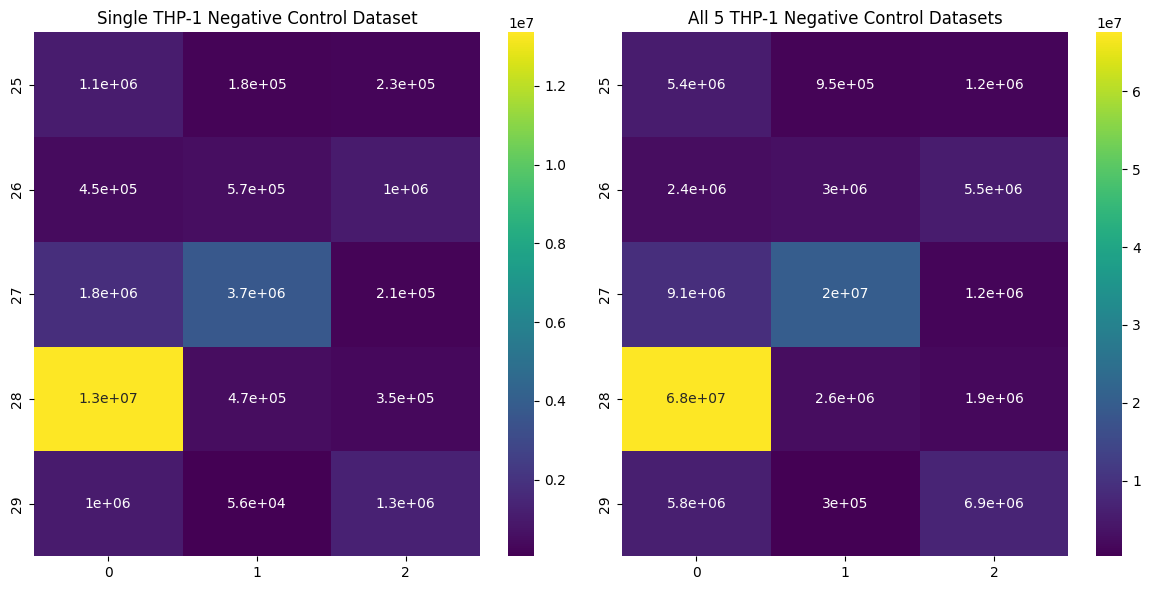

In [14]:
def size_and_frame_counts_heatmap(size_and_frame_df, min_size:int = None, max_size:int = None, ax=None):
    """Creates a heatmap of size x frame dataframe between

    Args:
        size_and_frame_df (_type_): _description_
        min_size (_type_): _description_
        max_size (_type_): _description_
    """    
    if min_size is not None and max_size is not None:
        indices = [i for i in range(min_size, max_size + 1) if i in size_and_frame_df.index]
        size_and_frame_df = size_and_frame_df.loc[indices]
    if ax is None:
        fig, ax = plt.subplots()
    sns.heatmap(size_and_frame_df, annot=True, cmap="viridis", ax=ax)
    return ax

min_fp_size = 25
max_fp_size = 29

min_size=13
max_size=36

fig, (ax01, ax02) = plt.subplots(1, 2, figsize=(12, 6))
size_and_frame_counts_heatmap(size_and_frame_singlerun, min_fp_size, max_fp_size, ax=ax01)
ax01.set_title("Single THP-1 Negative Control Dataset")
size_and_frame_counts_heatmap(size_and_frame_full, min_fp_size, max_fp_size, ax=ax02)
ax02.set_title("All 5 THP-1 Negative Control Datasets")
plt.tight_layout()
plt.show()